In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from arch import arch_model
from scipy.stats import genpareto
from statsmodels.graphics.gofplots import qqplot
from scipy.optimize import curve_fit, minimize
from scipy.interpolate import PchipInterpolator

In [2]:
df = pd.read_csv('/Users/balintmaroti/Documents/allianz/data/benchmark_combined.csv', parse_dates=['date', 'settle_date', 'maturity_date'])

In [3]:
# This new cell should be inserted after df is loaded and before it is pivoted.

# Define the mapping for tenor renaming
tenor_mapping = {
    '3 month': '3M',
    '6 month': '6M',
    '12 month': '1Y',
    '3 year': '3Y',
    '5 year': '5Y',
    '10 year': '10Y',
    '15 year': '15Y',
    '20 year': '20Y'
}

# Apply the renaming to the 'tenor' column
df['tenor'] = df['tenor'].replace(tenor_mapping)

# Define the desired order for tenors
tenor_order = ['3M', '6M', '1Y', '3Y', '5Y', '10Y', '15Y', '20Y']

# Convert 'tenor' column to a categorical type with the specified order
df['tenor'] = pd.Categorical(df['tenor'], categories=tenor_order, ordered=True)

# Sort the DataFrame by date and then by tenor.
# This ensures consistency and the pivot operation will respect the categorical order for columns.
df = df.sort_values(by=['date', 'tenor']).reset_index(drop=True)


In [4]:
# Pivot yields so that each tenor is a column
yld = df.pivot(index='date', columns='tenor', values='yield')



In [5]:
yld_diff = yld.diff().dropna()
yld_diff

tenor,3M,6M,1Y,3Y,5Y,10Y,15Y,20Y
date,,,,,,,,
2020-05-21,0.00,-0.01,-0.01,-0.10,0.02,0.04,0.01,0.01
2020-05-22,0.00,-0.01,-0.01,0.02,0.02,0.05,0.03,0.04
2020-05-25,0.00,0.00,0.01,0.00,0.00,0.00,0.00,-0.01
2020-05-26,0.08,-0.01,-0.03,0.01,0.02,0.10,0.12,0.12
2020-05-27,-0.06,-0.08,0.01,0.08,0.14,0.10,0.13,0.12
...,...,...,...,...,...,...,...,...
2025-05-19,-0.01,0.01,0.00,0.06,0.08,0.07,0.09,0.06
2025-05-20,0.01,0.00,0.00,-0.04,-0.06,-0.06,-0.05,-0.04
2025-05-21,0.06,0.00,0.01,0.08,0.09,0.07,0.07,0.07


In [6]:
df

,date,settle_date,tenor,isin_code,security,maturity_date,yield,change_pct,avg_bid_yield,avg_ask_yield,net_price,accrued_interest,source_file
0,2002-01-03,2002-01-07,3M,HU0000513379,D020417,2002-04-17,9.65,0.00,9.77,9.52,97.42560,0.0000,benchmark_01_02.xlsx
1,2002-01-03,2002-01-07,6M,HU0000513452,D020612,2002-06-12,9.39,0.00,9.50,9.27,96.14360,0.0000,benchmark_01_02.xlsx
2,2002-01-03,2002-01-07,1Y,HU0000513494,D021227,2002-12-27,8.96,0.00,9.08,8.83,92.00905,0.0000,benchmark_01_02.xlsx
3,2002-01-03,2002-01-07,3Y,HU0000402029,2004/J,2004-10-12,8.07,0.00,8.20,7.94,105.67165,4.3315,benchmark_01_02.xlsx
4,2002-01-03,2002-01-07,5Y,HU0000401963,2006/E,2006-05-12,7.58,0.00,7.70,7.45,105.16080,1.3041,benchmark_01_02.xlsx
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42101,2025-05-23,2025-05-27,3Y,HU0000405543,2028/B,2028-03-23,6.49,0.01,6.56,6.42,94.99390,0.8014,benchmark_24_25.xlsx
42102,2025-05-23,2025-05-27,5Y,HU0000403696,2030/A,2030-08-21,6.54,-0.01,6.62,6.47,84.70330,2.2932,benchmark_24_25.xlsx
42103,2025-05-23,2025-05-27,10Y,HU0000406624,2035/A,2035-10-24,7.00,0.01,7.07,6.93,99.94260,4.1233,benchmark_24_25.xlsx
42104,2025-05-23,2025-05-27,15Y,HU0000404165,2041/A,2041-04-25,7.22,-0.01,7.29,7.15,60.81900,0.2630,benchmark_24_25.xlsx


In [7]:
yld.describe()

tenor,3M,6M,1Y,3Y,5Y,10Y,15Y,20Y
count,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5836.000000,5835.000000,1255.000000
mean,5.198203,5.265308,5.323843,5.656698,5.745579,5.908322,5.986437,5.838717
std,3.777091,3.825420,3.779629,3.278178,2.829664,2.236210,1.953200,1.971685
min,-0.120000,-0.050000,-0.050000,0.170000,0.690000,1.470000,1.830000,2.410000
25%,0.950000,0.940000,1.000000,1.980000,2.660000,3.477500,3.880000,3.550000
50%,5.880000,5.900000,5.980000,6.580000,6.670000,6.650000,6.570000,6.630000
75%,7.902500,7.980000,8.000000,8.000000,7.730000,7.440000,7.340000,7.240000
max,14.940000,15.470000,14.640000,14.380000,13.440000,12.470000,11.650000,10.040000


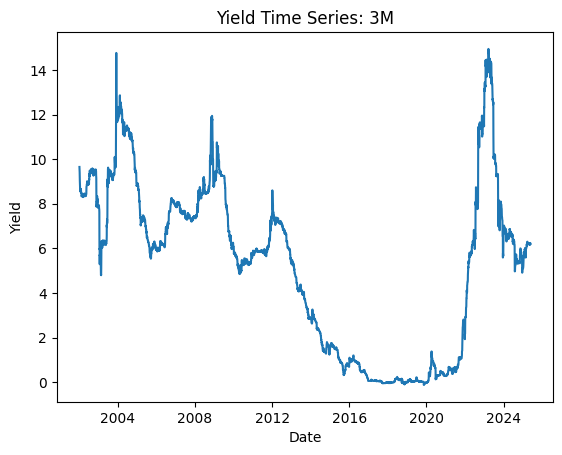

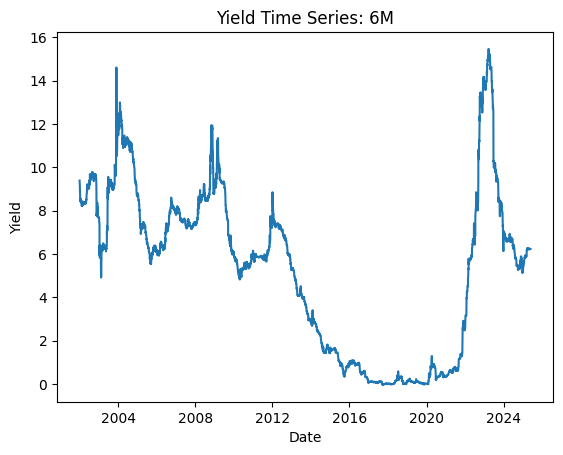

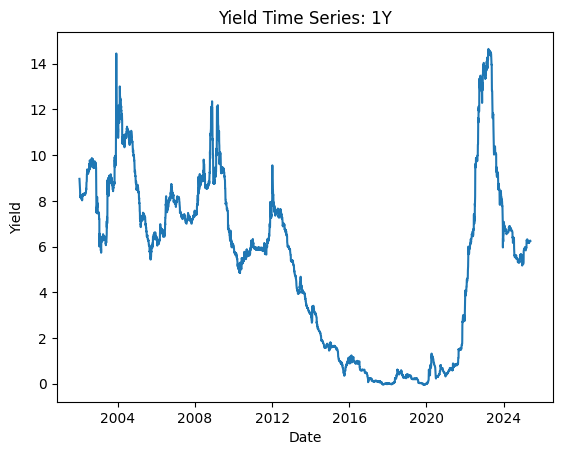

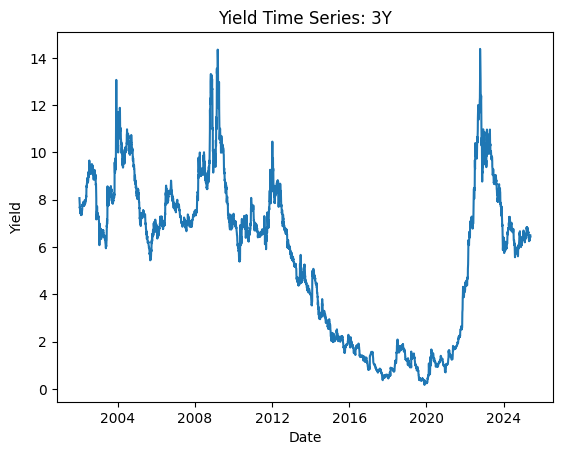

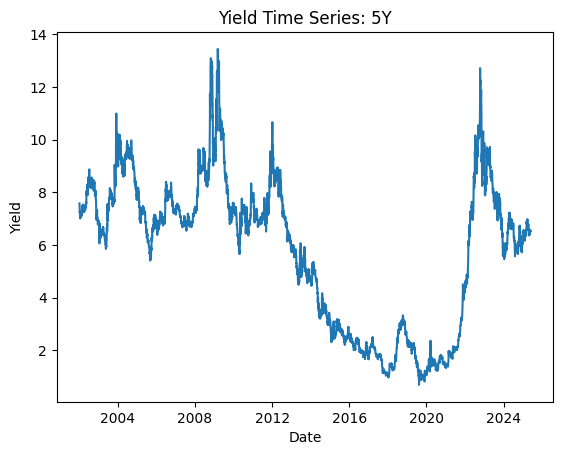

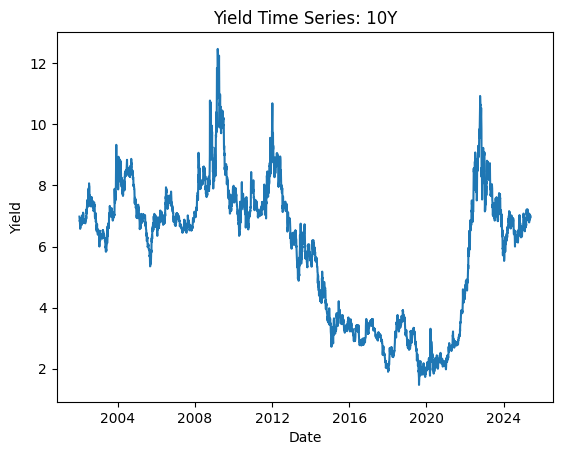

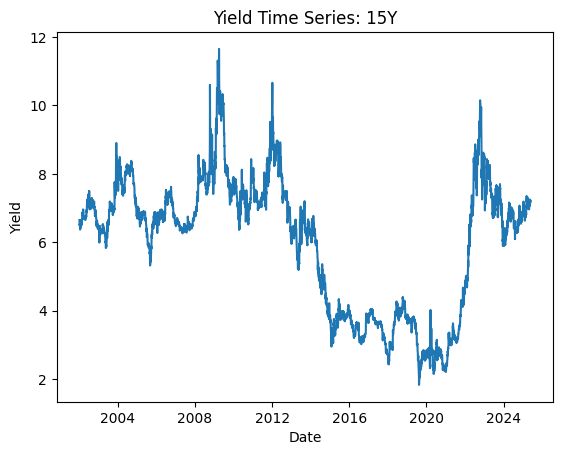

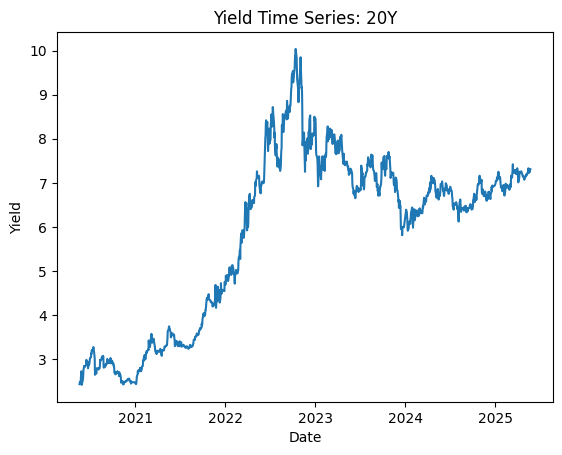

In [8]:
# Time-series plots of yields
for tenor in yld.columns:
    plt.figure()
    plt.plot(yld.index, yld[tenor])
    plt.title(f"Yield Time Series: {tenor}")
    plt.xlabel("Date")
    plt.ylabel("Yield")
    plt.show()

In [9]:
# descriptive statistics of yield changes
yld_diff.describe()

tenor,3M,6M,1Y,3Y,5Y,10Y,15Y,20Y
count,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000,1254.000000
mean,0.004338,0.004242,0.004258,0.004147,0.004051,0.004075,0.004011,0.003892
std,0.160307,0.121539,0.105918,0.128983,0.128653,0.120493,0.114544,0.114097
min,-1.290000,-1.430000,-0.920000,-1.220000,-1.020000,-0.980000,-0.780000,-0.750000
25%,-0.010000,-0.010000,-0.010000,-0.040000,-0.040000,-0.050000,-0.040000,-0.040000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000
75%,0.010000,0.010000,0.010000,0.040000,0.050000,0.050000,0.050000,0.050000
max,1.660000,1.370000,0.960000,1.310000,1.120000,0.630000,0.610000,0.630000


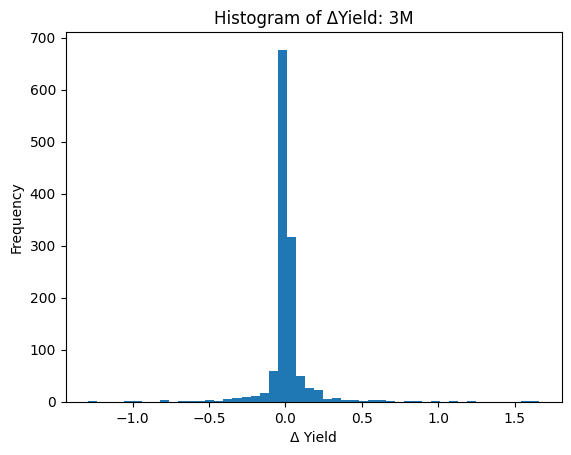

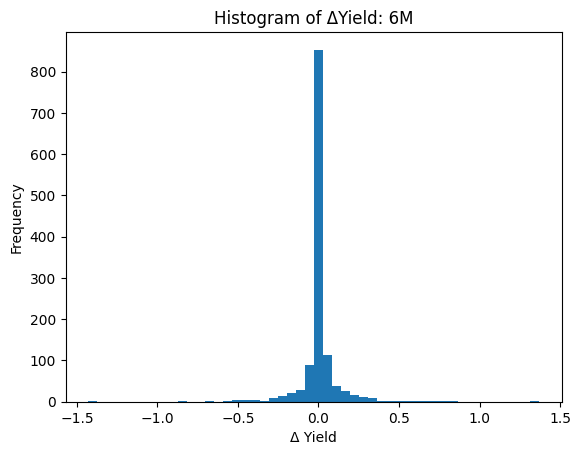

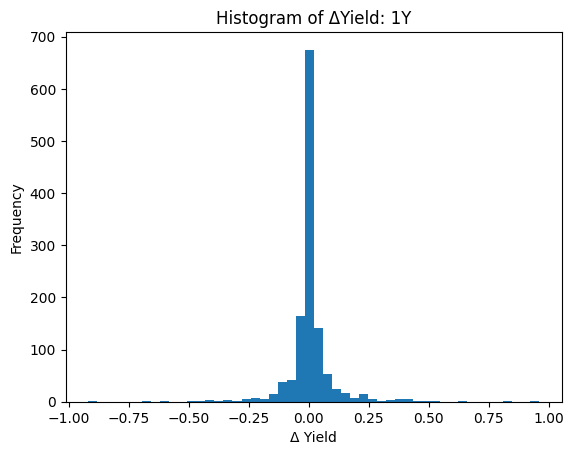

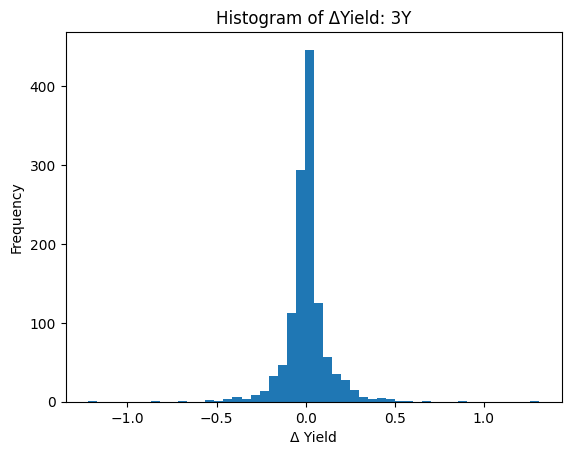

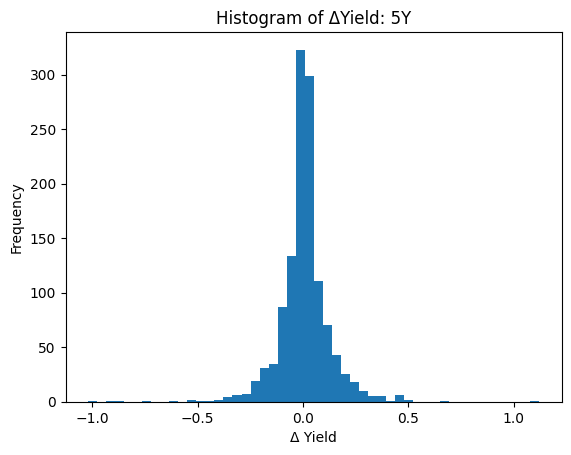

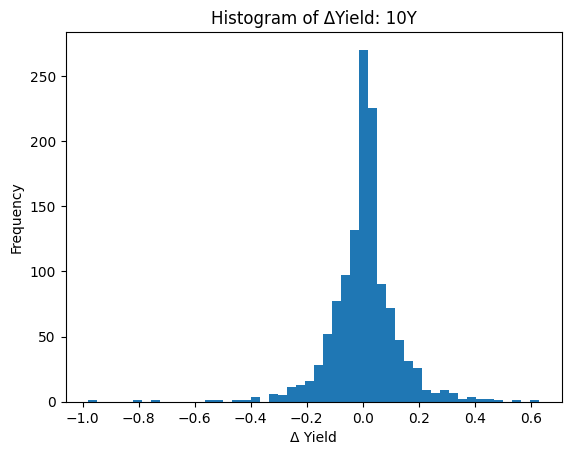

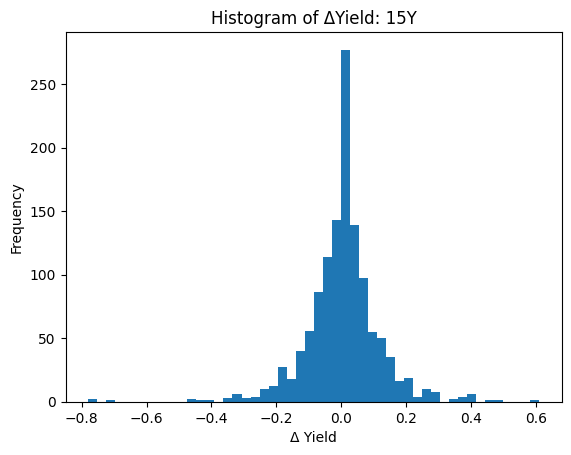

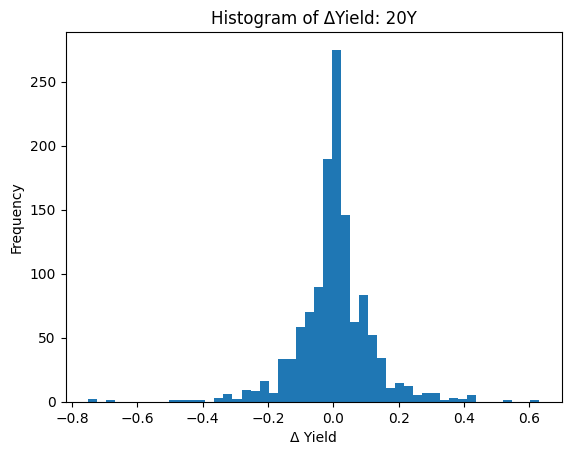

In [10]:
for tenor in yld_diff.columns:
    plt.figure()
    plt.hist(yld_diff[tenor], bins=50)
    plt.title(f"Histogram of ΔYield: {tenor}")
    plt.xlabel("Δ Yield")
    plt.ylabel("Frequency")
    plt.show()


Each tenor's daily change clusters around 0, which is expected when markets are on average stable.
Fat tails: compared to gaussian, we can see more observations in the extreme bins on both sides of the distribution, therefore there are more large jumps both to the upside and downside than a normal bell would predict. This indicates that we will need the GARCH rather than a simple gaussian to capture volatility clustering and fat tails.

Short tenors (3, 6 months) are close to symmetrical, while longer tenors (10, 15, 20 years) are slightly skewed(a bit more extreme negarttive jumps than positives). This implies that a seperate upper/lower tail model may be needed in the EVT step.

Volatility differences by tenor: the 3 month changes are noticably fatter, wider histogram, which is expected since short term yields tend to be more volatile more on a daily basis. This guides us to use a different GARCH model for the short tenor. 

In [11]:
# Compute skewness & kurtosis for each ΔYield series
sk = yld_diff.skew()
ku = yld_diff.kurtosis()

eda = pd.DataFrame({
    'skewness': sk,
    'kurtosis': ku
})

eda

,skewness,kurtosis
tenor,,
3M,1.054505,34.382077
6M,0.318428,37.915984
1Y,0.846349,21.026401
3Y,0.252645,20.786258
5Y,-0.437102,14.307216
10Y,-0.664141,8.599424
15Y,-0.471724,6.847293
20Y,-0.377776,6.463416


Kurtosis: the kurtosis is higher than 3 for all tenors, indicating that the tails are heavier than a normal distribution. This is consistent with the fat tails observed in the histograms. This indicates that student or skewed t-distributions may be more appropriate for modeling the returns, especially in the EVT step.

Skewness: Varies by tenor
Positive for 3m 6m and 12m, indicating fatter right tail meaning big upside jumps are more frequent
Negative for 10y, 15y, 20y indicating fatter left tail meaning big downside jumps are more frequent

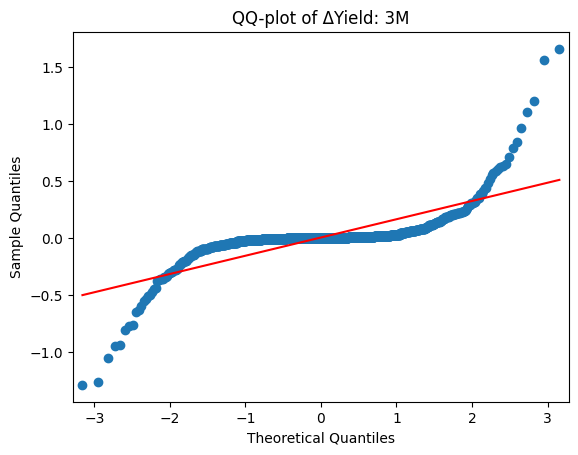

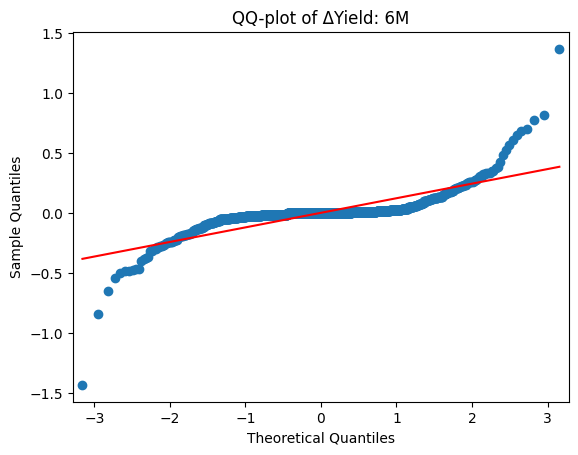

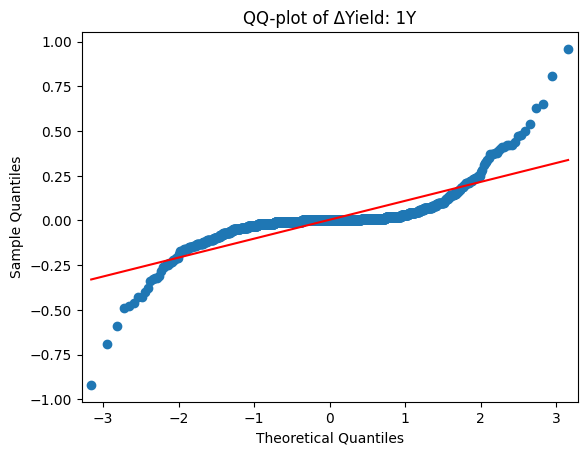

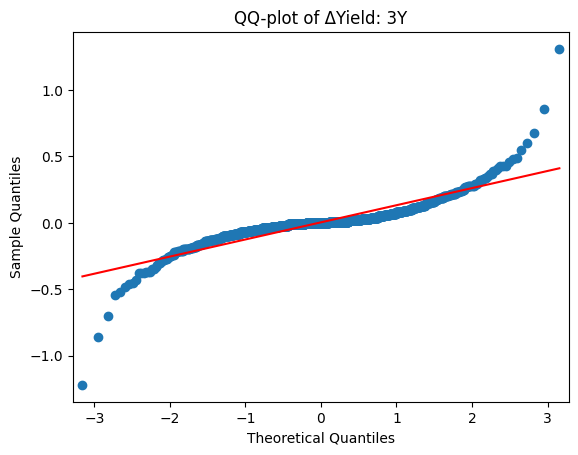

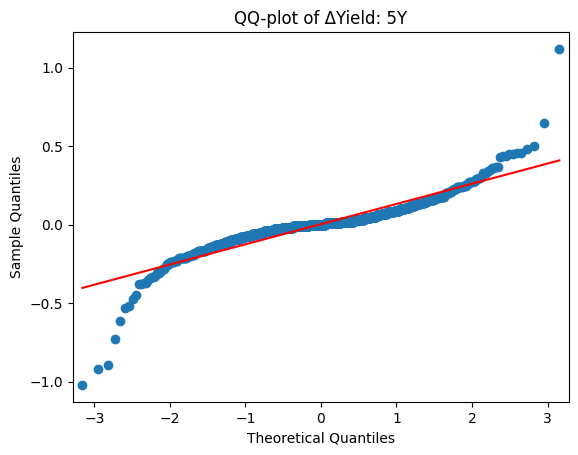

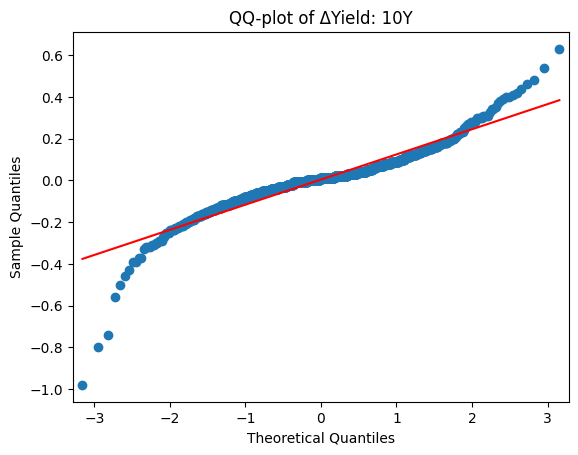

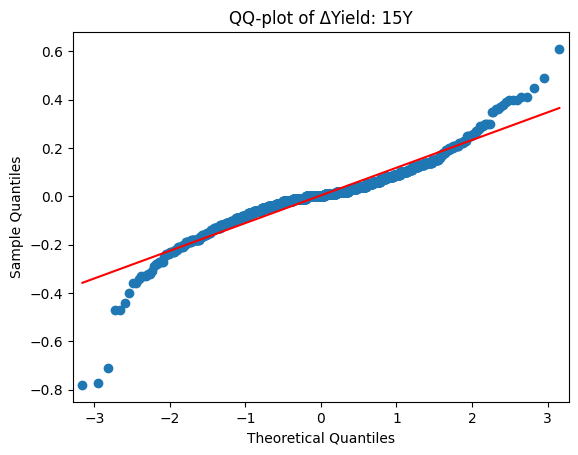

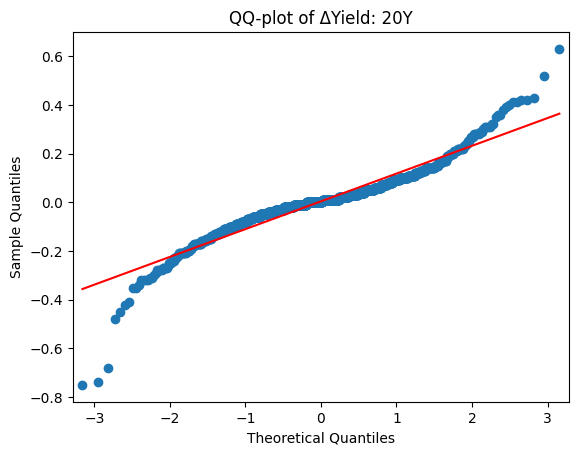

In [12]:
#QQ plots for each ΔYield series
for tenor in yld_diff.columns:
    qqplot(yld_diff[tenor], line="s")
    plt.title(f"QQ-plot of ΔYield: {tenor}")
    plt.show()

QQ plot evaluation:
Heavy tails:
Once again, heavy tails is justified, since the sample points depart from the straight reference line both in the upper and lower tails, indicating far more extreme moves than normal distribution would predict.
Skewness:
hSort-term bonds (3m, 6m, 12m) show more extreme positive jumps than negative, while long-term bonds (10y, 15y, 20y) show more extreme negative jumps than positive. This is consistent with the skewness observed in the histograms.

Overall, a student t is a bare minimum which allows symmetric fat tails given the kurtosis. Tenors with pronounced skew probably need a skew-t in the GARCH step to capture assymetric tail behavior.
These also suggest choosing Peak over threshold(POT)-EVT for seperate up/down tail modeling, especially for the long tenors.
https://github.com/mangushev/EVT_POT 

In [13]:
# 5. Stationarity test (ADF) on Δy
adf_results = {}
for tenor in yld_diff.columns:
    stat, pval, *_ = adfuller(yld_diff[tenor])
    adf_results[tenor] = {"ADF Stat": stat, "p-value": pval}
adf_df = pd.DataFrame(adf_results).T
adf_df


,ADF Stat,p-value
3M,-17.365405,5.174625e-30
6M,-6.152106,7.518961e-08
1Y,-5.398583,3.410494e-06
3Y,-7.622400,2.111476e-11
5Y,-8.655604,4.978808e-14
10Y,-8.103763,1.279074e-12
15Y,-7.548698,3.231733e-11
20Y,-8.373224,2.627882e-13


p-values are lower than 0.05, indicating that the results are statistically significant. This implies stationarity in the TS, no need for further differencing.

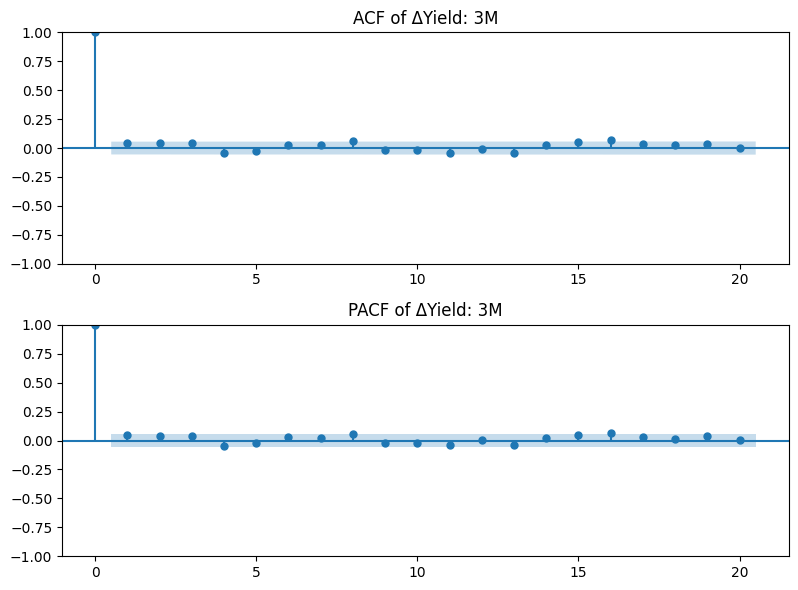

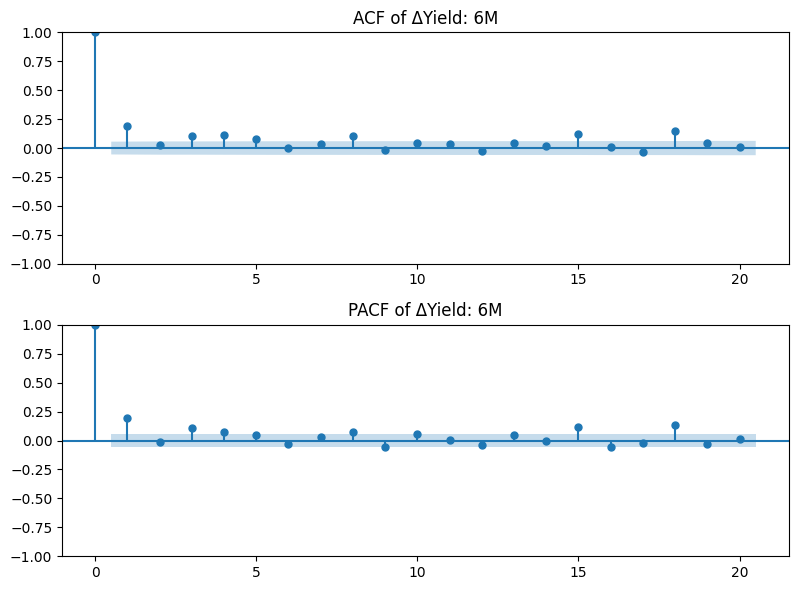

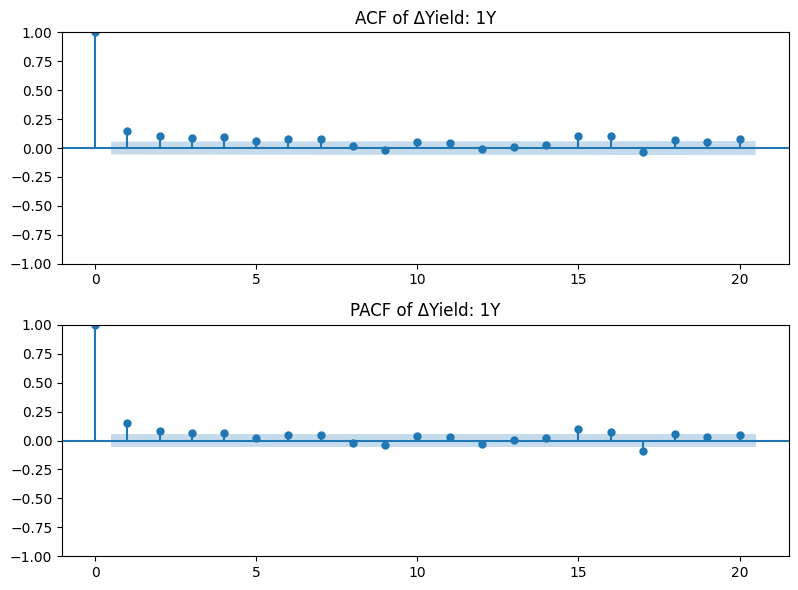

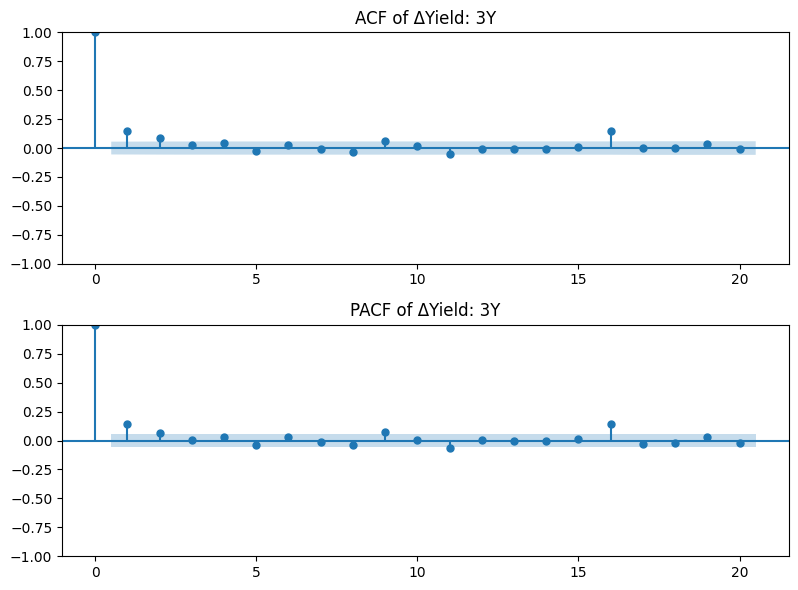

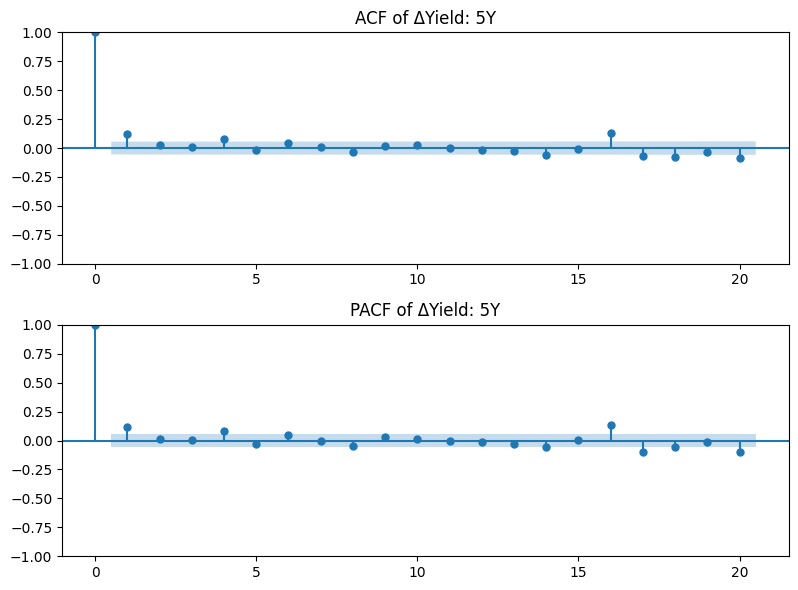

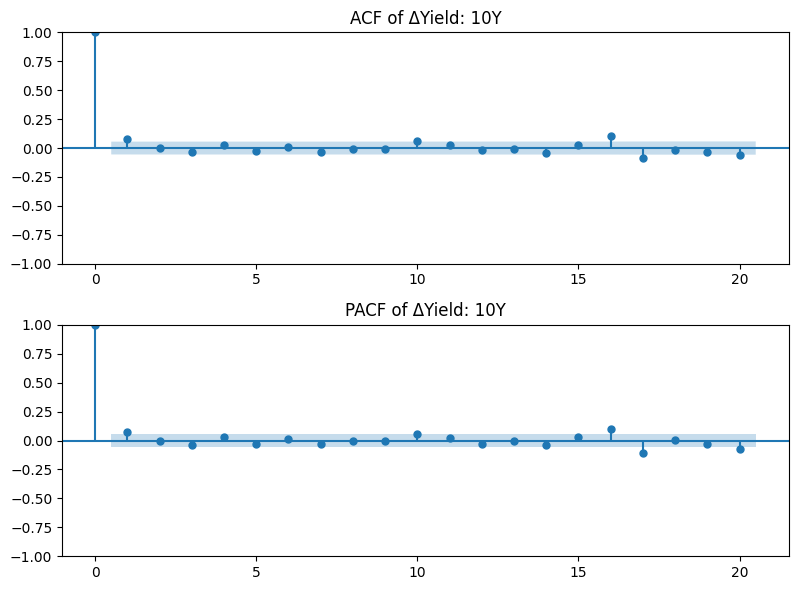

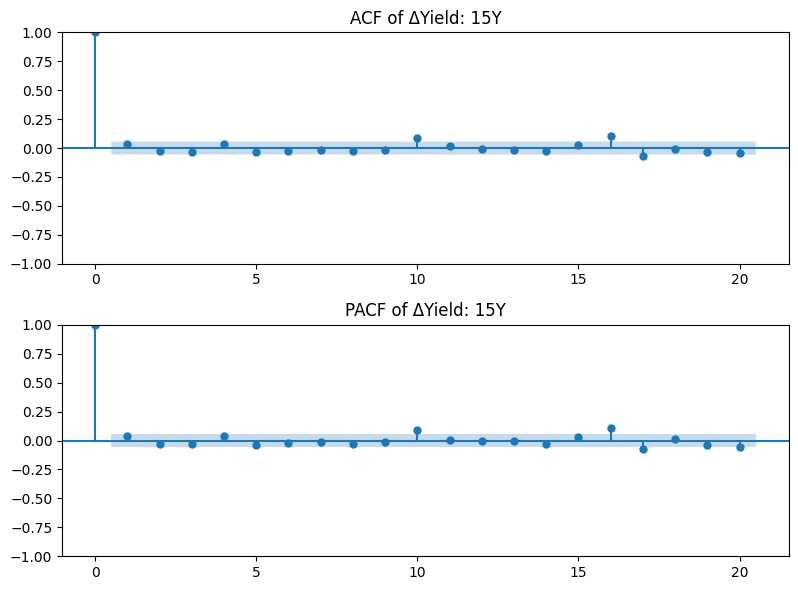

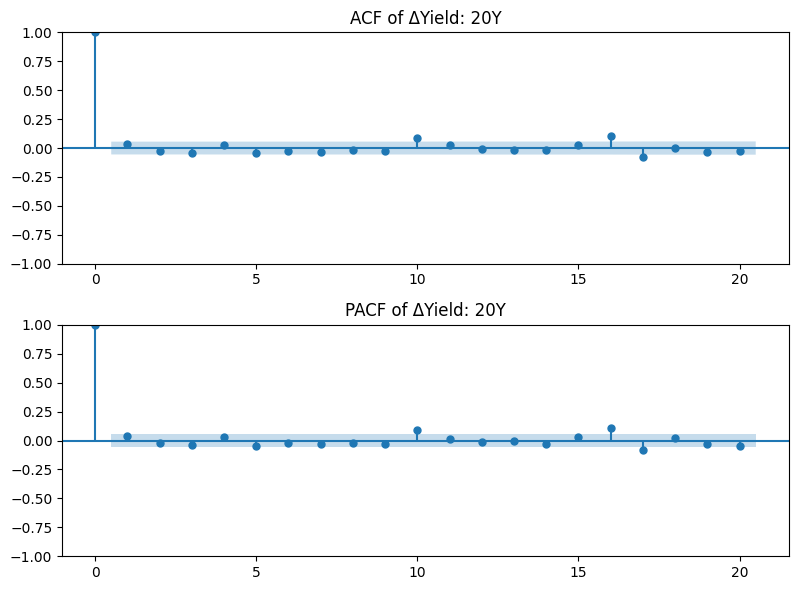

In [14]:
# Plot ACF and PACF for each tenor 
# This will help identify the order of ARMA model
for tenor in yld_diff.columns:
    fig, axes = plt.subplots(2, 1, figsize=(8, 6))
    plot_acf(yld_diff[tenor], lags=20, ax=axes[0], alpha=0.05)
    axes[0].set_title(f"ACF of ΔYield: {tenor}")
    plot_pacf(yld_diff[tenor], lags=20, ax=axes[1], method='ywm', alpha=0.05)
    axes[1].set_title(f"PACF of ΔYield: {tenor}")
    plt.tight_layout()
    plt.show()

General observations across tenors
ACF is essentially zero after lag 0
Apart from the trivial spike at lag 0 (autocorrelation of the series with itself), all ACF bars lie within the significance bands.
Implication: No strong MA(q) component is needed beyond chance noise because the ACF is close to zero.

PACF shows one small but significant spike at lag 1
Almost every tenor has a PACF spike at lag 1 just outside the confidence band, then cuts off.
Implication: A single AR(1) term captures most of the autocorrelation in ΔYield.

Occasional “blips” at lags 2–3 in long maturities
For 10-year or 20-year, you might spot one or two minor PACF spikes at lag 2 or 3, but they’re marginal.
Implication: You could test AR(2) for those tenors, but AR(1) will likely suffice.